In [3]:
from opty import Problem, create_objective_function, parse_free
import sympy as sp
import numpy as np
import scipy as sc
import time as tm
import pickle
import sympy.physics.mechanics as me
import sys
sys.path.insert(0, "..")
from importlib import reload
motion_folder = 'Steering'
motion_name = 'steering.mat'
struct_name = 'results_quat_QuatInit_150_02.mat'
initPos = 'InitPosOptQuat'
traj_w = 150
vel_w = 0.1
act_w = 1

In [7]:
import equations as eq
reload (eq);

model_struct = sc.io.loadmat('../Motions/'+motion_folder+'/OS_model.mat')
data_struct = sc.io.loadmat('../data_model.mat')
start = tm.time()
# MM,FO,q,w,u0,fr,frstar,kinematical,xdot,holonomic = eq.create_eoms_u0state(model_struct,data_struct,initPos,derive = 'numeric')
# TE,activations = eq.polynomials_quat(model_struct = model_struct,q = q,derive = 'numeric',model_params_struct = data_struct ,initCond_name = initPos)
q = eq.create_eoms_u0state(model_struct,data_struct,initPos,derive = 'numeric')

time_to_create = tm.time() - start
print(time_to_create)

0.2520279884338379


In [8]:
eq.objective_rotglob_quat(len(q),1)

Matrix([[(x1 - x_traj1)**2 + (x10 - x_traj10)**2 + (x11 - x_traj11)**2 + (x12 - x_traj12)**2 + (x13 - x_traj13)**2 + (x2 - x_traj2)**2 + (x3 - x_traj3)**2 + (x4 - x_traj4)**2 + (x9 - x_traj9)**2 + (x1*x5 - x2*x6 - x3*x7 - x4*x8 - x_traj5)**2 + (x1*x6 + x2*x5 + x3*x8 - x4*x7 - x_traj6)**2 + (x1*x7 - x2*x8 + x3*x5 + x4*x6 - x_traj7)**2 + (x1*x8 + x2*x7 - x3*x6 + x4*x5 - x_traj8)**2]])


In [3]:
import equations as eq
reload (eq);
# dict_vals,symlist, value_list = eq.create_parameters_dict(data_struct, initPos)
x0 = data_struct['params'][initPos][0,0]['initCondQuat'].item()
x0t = list(x0.T[0])

In [4]:
eoms_implicit = sp.Matrix(kinematical).col_join(fr+frstar+TE).col_join(holonomic)

In [5]:
import trajectory_lib as tr
reload (tr);
num_nodes = 101
file = '../Motions/' + motion_folder + '/' + motion_name
traj, interval_value, time = tr.exp_trajectory_quat(file,num_nodes)

state_symbols = tuple(q+w+u0)
num_states = len(state_symbols)
specified_symbols = tuple(activations)
num_inputs = len(specified_symbols)
t = me.dynamicsymbols._t

In [6]:
def obj(free):
    min_traj = traj_w * interval_value * np.sum((traj - free[:13*num_nodes])**2)
    min_vel = vel_w * interval_value * np.sum((free[13*num_nodes:num_states*num_nodes])**2)
    min_torque = act_w * interval_value * np.sum(free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
    return min_traj + min_torque + min_vel

def obj_grad(free):
    grad = np.zeros_like(free)
    grad[:13*num_nodes] = traj_w * 2.0 * interval_value * (free[:13*num_nodes] - traj)
    grad[13*num_nodes:num_states*num_nodes] = vel_w * 2 * interval_value * free[13*num_nodes:num_states*num_nodes]
    grad[num_states*num_nodes:(num_states + num_inputs)*num_nodes] = act_w * 2.0 * interval_value * free[num_states*num_nodes:(num_states + num_inputs)*num_nodes]
    return grad

In [7]:
instance_constraints = []
# for i in range(13):
instance_constraints.append(state_symbols[-3].func(0.0)-0) 
    
bounds1 = (0.0,1.0)
bounds = (bounds1,)*len(activations)
bndrs = dict(zip(activations,bounds))

In [8]:
start = tm.time()
prob = Problem(obj, obj_grad, eoms_implicit, state_symbols,
               num_nodes, interval_value,
               known_parameter_map={},
               instance_constraints=instance_constraints,
               bounds=bndrs,
               integration_method='midpoint')


time_to_create = tm.time() - start
print(time_to_create)



1274.312983751297


In [9]:

prob.add_option('max_iter',3000)
prob.add_option('limited_memory_max_history', 40)

In [10]:
initial_guess = np.zeros(prob.num_free)
initial_guess[:13*num_nodes] = traj

In [11]:
time_2_solve_start = tm.time()
solution, info = prob.solve(initial_guess)
time_2_solve = tm.time() - time_2_solve_start
print(info['status_msg'])
print(info['obj_val'])
act_obj = np.sum(solution[num_states*num_nodes:(num_states + num_inputs)*num_nodes]**2)
print('Objective activations: ', act_obj)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:   800801
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    15554
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    12928
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2601
Total number of inequality c

 152  5.3164682e+00 6.38e-03 1.10e-02  -6.0 2.53e-02    -  1.00e+00 1.00e+00h  1
 153  5.3149358e+00 7.07e-04 1.91e-02  -6.1 3.52e-03    -  1.00e+00 1.00e+00h  1
 154  5.3148157e+00 2.45e-04 7.20e-03  -6.1 3.59e-03    -  1.00e+00 1.00e+00h  1
 155  5.3149593e+00 9.06e-06 3.18e-02  -6.1 1.99e-03    -  1.00e+00 1.00e+00H  1
 156  5.3108378e+00 5.20e-04 1.95e-02  -7.2 1.01e-02    -  1.00e+00 6.75e-01h  1
 157  5.3107634e+00 2.39e-05 3.51e-02  -6.6 9.96e-03    -  1.00e+00 1.00e+00H  1
 158  5.3091010e+00 2.41e-03 9.21e-03  -6.9 6.26e-03    -  1.00e+00 1.00e+00h  1
 159  5.3084685e+00 8.33e-05 4.92e-03  -7.7 1.60e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  5.3085786e+00 9.39e-04 1.07e-02  -7.4 3.88e-03    -  1.00e+00 1.00e+00h  1
 161  5.3085220e+00 6.01e-04 9.11e-03  -7.5 2.41e-03    -  1.00e+00 1.00e+00h  1
 162  5.3085408e+00 1.42e-06 1.59e-02  -7.5 1.97e-03    -  1.00e+00 1.00e+00H  1
 163  5.3083170e+00 3.76e-04

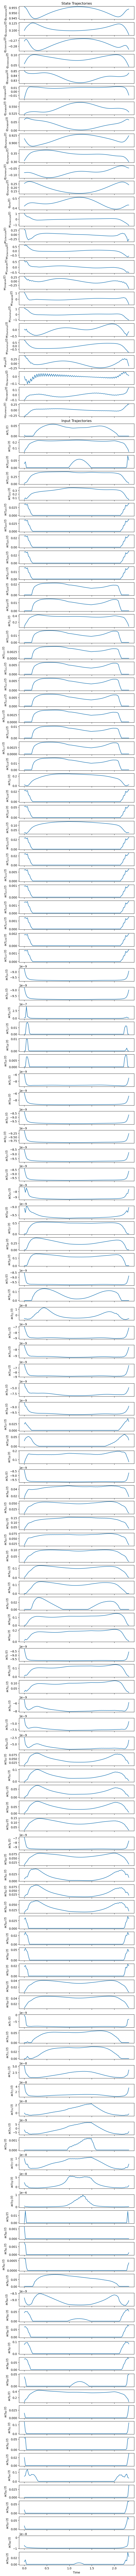

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(int(num_states+num_inputs), 1, sharex=True,
                         figsize=(6.4, 0.8*(num_states+num_inputs)),
                         layout='compressed')
prob.plot_trajectories(solution, axes=axes)

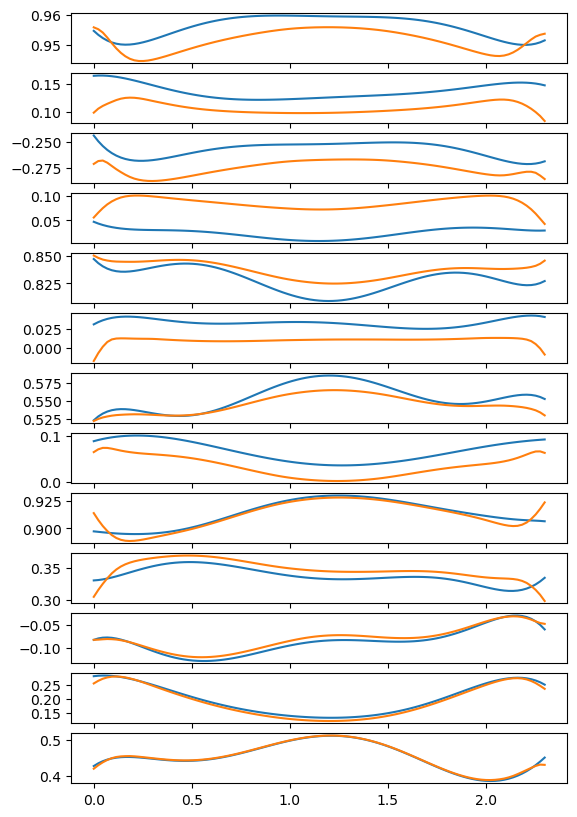

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(13)
for j in range(13):
    axs[j].plot(time,traj[j*num_nodes:(j+1)*num_nodes])
    axs[j].plot(time,solution[j*num_nodes:(j+1)*num_nodes])
    fig.set_figheight(10)

In [14]:
import trajectory_lib as tr
reload (tr);
num_iter_sol = int(input('enterr number of iterarions:'))
file_name = '../Motions/'+motion_folder+'/' + struct_name
tr.sol2struct(solution,activations,len(q),num_states,num_nodes,time,num_iter_sol,time_2_solve,file_name)

Saved to .mat file


In [15]:
import trajectory_lib as tr
reload (tr);

file_name_mot = '../Motions/'+motion_folder+'/results_quat2.mot'
tr.sol2mot_quat(solution,num_nodes,13,time,file_name_mot)


Saved to .mot file
